# Homework 1: Artificial Neural Networks
This notebook will cover what we discussed during our interactive sessions. You'll change the model parameters and try to get the best accuracy possible, which you can then submit to the Kaggle competition to see how everyone's model compares!

Our goal in this homework is to accurately predict cardiovascular diseases in patients.

[Click here to open the kaggle competition and notebook!](https://www.kaggle.com/t/54024af83f0140889d7eb1572cdeae1c)

## Importing Libraries
First off, to use the libraries that will handle the data processing and training the model, we must import them first. Importing in Python is simple, using the `import` keyword. 

The libraries we will be using are:
- Pandas: handles loading, analyzing, and manipulating the data set
- Numpy: handles matrix operations
- Sklearn: large library for data science, we will use it for scaling, splitting, and removing outliers from the data set
- Tensorflow and Keras: These are the libraries used for creating and training the Neural Network.
- Matplotlib: This is used for generating graphs, in this case for graphing the model's loss as it trains.
- OS: Library included with Python for handling I/O and other OS level operations

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# the from keyword allows for importing a specific function from a library, rather than the whole library itself
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
#from sklearn.ensemble import IsolationForest

from keras.layers import Dropout, Dense
from keras.models import Sequential, load_model
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import optimizers as opt
from tensorflow.random import set_seed

## Seeding
In order to reproduce results and more accurately compare the different outlier detection methods, everything is seeded with the same seed such that data splits are consistent and models are initialized the same way on every run. This will also make it easier to compare your model's predictions with other people who use the same seed, since the only thing changing is the model itself and everything else is kept consistent.

In [ ]:
# seed everything the same for more accurate comparsions between models and outlier methods
seed = 42
np.random.seed(seed)
set_seed(seed)

## Dataset Analysis
The Cardiovascular Disease dataset we will be using can be found on kaggle [here](https://www.kaggle.com/datasets/sulianova/cardiovascular-disease-dataset?select=cardio_train.csv). It contains a number of different columns (we call these *features*) that have a variety of information for a specific patient. Given that information, we want to predict whether they have a cardiovascular disease or not. 

The first step in building an AI model has nothing to do with model itself, rather we must analyze and process our dataset before the model can train. This is almost always needed in order for the model to train properly, as not doing any processing will usually lead to poor model performance.

Our first step is the most important: understanding what the dataset contains. Here is each feature the dataset has:
1. Age (age): int (days)
2. Height (height): int (cm) 
3. Weight (weight): float (kg) 
4. Gender (gender): categorical code
5. Systolic blood pressure (ap_hi): int
6. Diastolic blood pressure (ap_lo): int 
7. Cholesterol (cholesterol): categorical 1: normal, 2: above normal, 3: well above normal
8. Glucose (gluc): categorical 1: normal, 2: above normal, 3: well above normal
9. Smoking (smoke): binary 0: no, 1: yes
10. Alcohol intake (alco): binary 0: no, 1: yes
11. Physical activity (active): binary 0: no, 1: yes
12. Presence or absence of cardiovascular disease (cardio): binary 0: no, 1: yes

Let's explore what these features mean a bit more:
- Blood pressure: When you get your blood pressure taken at a doctor's office, you'll see two numbers, one at the top and on at the bottom on the machine they use. The top number is the  **Systolic blood pressure** and represents the pressure of when your heart beats to push blood through your arteries. The bottom number is the **Diastolic blood pressure** and represents the pressure in your arteries when your heart is at rest between each beat.
- What we are trying to predict: From the list features 1-11 are going to be our **input** features, which is what the model will be using to learn. Number 12 is going to be our label (also called y, or target) which is the value we are trying to predict. Since the value is either 0 or 1, this is called **binary** prediction.

Now that we know what the dataset is going to look like, lets load it and see for ourselves! We will be using **pandas** to load and analyze the dataset. Take note of the different functions we use to see what the dataset contains.

In [ ]:
# get path to data, if running on kaggle it will be /kaggle/input or if you are running this notebook locally it will be in data folder
data_dir = os.path.join("/kaggle", "input", "ai-webdev-hw1")
if not os.path.isdir(data_dir):
    data_dir = "data"

# load dataset with index column being the first column in the file
df = pd.read_csv(os.path.join(data_dir, "cardio_train_new.csv"), index_col=0)
# print the first 5 rows in the dataset
df.head()

In [ ]:
# this function will give us the number of entries, count any null or NaNs in each column, and give the datatype
df.info()

In [ ]:
# This is always important, as you need to make sure there are no NaNs in the dataset. This is a simple way to count them
# For our dataset we do not have any NaNs, hooray!
df.isna().sum()

In [ ]:
# This function gives some basic statistical information on the dataset including mean, std, min, max, for each column
df.describe()

### Spot an issue?
If you saw that the blood pressure has negative values, good catch! As we can see from the dataset description we have negative values for both `ap_hi` and `ap_lo` (Systolic and diastolic) blood pressures. Since its impossible to have a negative blood pressure we need to investigate these negative values and decide what to do with them.

First, we can count the number of rows that have negative values, and also view the row themselves. To find all the rows where `ap_hi` is negative is simple with pandas. We can index the variable `df` with the column name `ap_hi` and use a logical comparison operator `<` to find **all** rows where `ap_hi` is less than zero.

In [ ]:
negative_hi_values = df["ap_hi"] < 0
print(negative_hi_values.sum()) # counts how many rows have a negative `ap_hi` value

df[negative_hi_values] # prints the rows with negative `ap_hi`

In [ ]:
# same as above for `ap_low`
negative_lo_values = df["ap_lo"] < 0
print(negative_lo_values.sum())

df[negative_lo_values]

### So, what do we do?
There are a few options we have for dealing with this issue. Since there are only a few rows affected, the simplest issue is to just remove the rows with these invalid values. You may also notice that the negative values seem to be an error in input, since the absolute value looks like a valid blood pressure.

However, since we can't be 100% sure that the values were just incorrectly entered, its best to remove these from the dataset. Doing so is very simple, we can just update the `df` dataframe variable with all the values where the blood pressure is positive.

In [ ]:
# remove negative blood pressure values
pos_bp = df["ap_hi"] > 0
df = df[pos_bp]

pos_bp = df["ap_lo"] > 0
df = df[pos_bp]

In [ ]:
df.describe() # no more negative blood pressures!

### Wait, there are other issues too!
If noticed more issues with blood pressure, you got a good eye! Negative values aren't just the main issue, we have people with a blood pressure of 1, 6, and also 14020 and 11000. Obviously, if someone actually had these blood pressure they would be very dead, so those rows don't make much sense. We call these rows **outliers**, as in they are very far away from the rest of the dataset. The best way to spot outliers is looking at the mean value and the min/max values for each column, if the min or max is very far away from the mean we can guess that there are outliers.

Let's fix the issues of both minimum and maximum blood pressure.

In [ ]:
bp_range = (50, 250) # remove extreme cases for blood pressure that don't make sense, so keep blood pressures in the range of 50 and 250

df = df[(df["ap_hi"] > bp_range[0]) & (df["ap_hi"] < bp_range[1])]
df = df[(df["ap_lo"] > bp_range[0]) & (df["ap_lo"] < bp_range[1])]

In [ ]:
df.describe() # looking good

### Class balance
Finally, one of the most important things to look at in any dataset is class balance. Classes in a dataset are the unique values for the label (what we are trying to predict). Because our label is binary, we only have two classes: 0 for no cardiovascular disease and 1 for cardiovascular disease. Different datasets can have any number of classes, but this idea applies to all of them. 

Class balance is the balance of how many rows belong to each of the classes. For example, a poor class balance would be 80% of the dataset having a class of 0, and 20% having a class of 1. This can heavily bias your model. Following the same example, a model that always predicts 0 would have an accuracy of 80%! While that accuracy may seem good it is not a very good model, so taking measures to balance our dataset is important.

Let's look at our class balance for this dataset:

In [ ]:
class1 = df[df["cardio"] == 0]["cardio"].count()
class2 = df[df["cardio"] == 1]["cardio"].count()

print(f"Number of samples with class 0 (no cardiovascular disease): {class1}")
print(f"Number of samples with class 1 (cardiovascular disease)   : {class2}")

As you can see, our dataset is fairly balanced, so we don't need to do anything more. If you want to learn more about how to solve the issue of class balancing, look into `class weighting`.

## Dataset Cleaning

### Scaling
Scaling a dataset is extremely important in any application. Models train better when all of the input features (columns) are in a similar range to each other. If we do not scale, the model may weight larger values more than smaller values, rather then the actual information those values represents. When we scale the data, we aren't removing any information, simply transforming it into something the model can better understand.

We only want to scale data that is **not** categorical, as it doesn't make sense to scale these features that only represent a category and not a continuous value. 

Since all of our categorical features (like smoking, alcohol, gender, etc) are binary (0 or 1), we can leave them as is. However if you have a category with a lot of different values (like 0 to 10000) you can run into the same issue as mentioned above. To fix these these, we can use `one hot encoding` to represent them in a way the model won't be biased for the larger values, which we will cover in a future lesson.

We will use the `StandardScaler`, which will scale the numerical features into a **normal distribution**.

In [ ]:
labels = df["cardio"]
# take our labels into a seperate variable and remove it from our dataset
df = df.drop("cardio", axis=1)

# only need to scale numeric data, data that is categorical (categories, like gender being either M or F) do not need scaling
numerical_columns = ["age", "height", "weight", "ap_hi", "ap_lo"]

scaler = StandardScaler() # scale to normal distribution for each feature
scaler.fit(df[numerical_columns])
df_scaled = df.copy()
df_scaled[numerical_columns] = scaler.transform(df[numerical_columns])

In [ ]:
df_scaled.describe() # all normalized!

### Training, Validation, Testing Data Split
We have made it this far, the dataset is now ready to be used! In order to properly train the model, we need to split the dataset into different sets: **Training, Validation, and Testing**. The **Training** split will be used to train the model to predict our label. The **Validation** dataset will be used to *validate* the model as it trains. This means after each Epoch the model will be tested on the validation data (which it has never seen/been trained on) to see if there is improvement. The **Testing** split will be used after the model finishes training to get a final evaluation on the model performance on new data.

This is done to detect **overfitting**, which is when the model *memorizes* the training data instead of learning it's patterns. When testing on the validation data it is easy to see if the model is overfitting by looking at it's performance on the training data vs the validation data. If it performs well on the training data but poor on the validation data, the model is overfitting to the training data. 

When training, we want to see the validation accuracy increase as well as training accuracy, as the validation accuracy is a better indicator of the model's performance on data it has not been trained on. 

It is common to use the validation split was the testing split, so we will split the data set into two chunks. The first split will be 80% of the data and will be our training set. The validation/testing split will be the rest of the data (20%) which we will use to evaluate the model while it is training to make sure it is performing well.

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df_scaled, labels, test_size=0.2, random_state=seed)
# x is the input data, y is the label.

## Model Architecture
Now that the dataset is ready to go, we can build our model for predicting cardiovascular disease. There are many aspects of a model, with a ton of parameters that we can change and tune to get the model to perform the best. It is important to understand each aspect and what it means for the model before we build the model.

### Activation Functions
Activation functions gives a model it's ability to learn non-linear patterns in data. A neural network with no activation functions can only learn linear relationships in data, and in most cases reality is not linear. These functions modify the output of each layer. Refer back to the lesson notebook to see how exactly this occurs.

Lets take a look at some different activation functions: 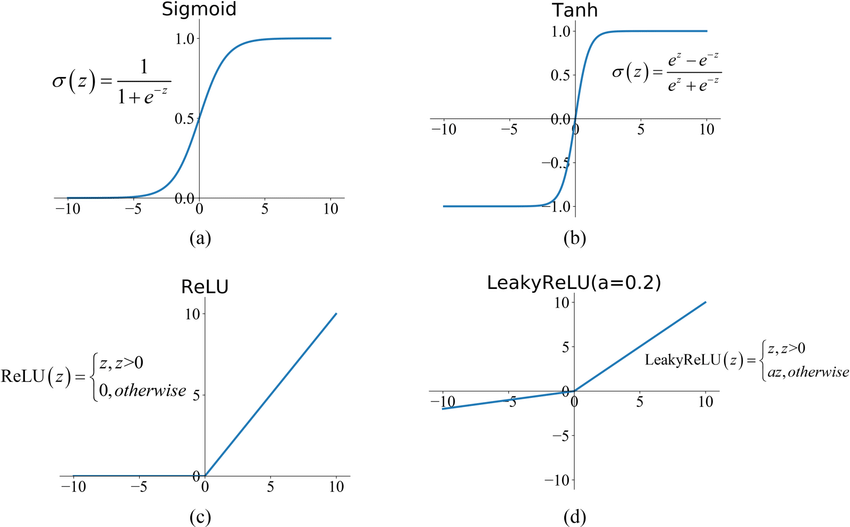

#### What activation functions should I use?
That is a hard question to answer, since everything depends on the dataset. When creating a new model it is good to try ReLU, Sigmoid, and Tanh as your activation functions for **hidden** layers, one of these will usually outperform the others, try first using the same activation function for all hidden layers, as mixing them usually won't provide any performance boost. 

For the output layer, the activation function depends on what you are trying to predict. For regression problems, where you are predicting a value like house prices, you don't want any activation function (this is called linear activation). For classification problems, there are a few different situations:
- Multiple classes, single prediction: Softmax
- Multiple classes, multiple prediction: Sigmoid
- Binary classification: Sigmoid

Multiple classes means more than 2 classes (which is binary). Multiple prediction is predicting multiple labels per row. For example, if I have an image as input and I want to classify the objects in the image, I want to use multiple predictions since there can be multiple objects in a single image.

Since we are doing binary classification, our output layer will use the Sigmoid activation function, which can be seen as a "confidence" score where predictions greater than or equal to 0.5 is classified as label 1, and under 0.5 is label 0. 

### Dropout
Dropout is a method of model regularization to reduce overfitting. The idea behind dropout is to stop nodes in the hidden layer from being weighted too highly. For example, a layer with 50 nodes may have 1 node that is weighted much higher then the rest of the 49 nodes, meaning that changes in that node drastically change the output, and the other 49 nodes don't affect the output at all, which is behavior we want to avoid. Dropout works by "turning off" some nodes in a layer which forces the model to use the other nodes to make the correct prediction. This is only done during training, and is done to a random set of nodes on each forward pass.

Dropout in Keras is defined as a percentage (0 being no nodes, 1 being all nodes) of nodes to dropout for a hidden layer.

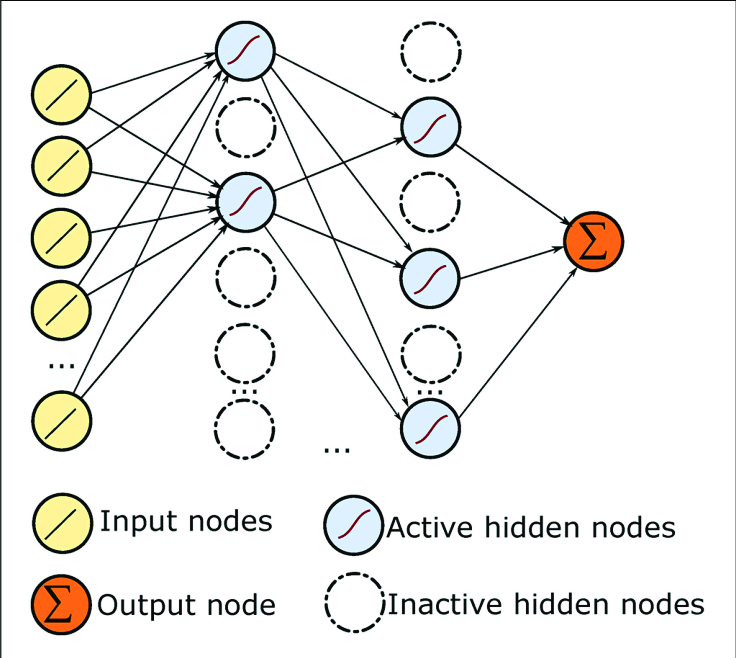

### Building the model
Let's get to the fun part of building the model! Below, I have laid out an example. You can change the number of nodes in each layer by changing the `<num_nodes>` variable for each layer. I also included two dropout layers which you can change as well.

What you need to do:
- Change `<num_nodes>` to the number of nodes you want in each layer
- Change `<activation>` To the activation function you want to use. Replace it with one of these:
    - "relu"
    - "sigmoid"
    - "tanh"
- Change `<dropout>` to a value between 0 and 1 for the percentage of nodes to drop when training
- Add or remove layers! Simply copy this to add another layer: `model.add(Dense(<num_nodes>, activation=<activation>))` or dropout: `model.add(Dropout(<dropout>))`

**Do not modify the output layer**, as it is already set to work with our dataset.

In [ ]:
model = Sequential()

# Input layer, the input_shape argument is the number of features in our dataset, in this case 11
model.add(Dense(<num_nodes>, activation=<activation>, input_shape=(x_train.shape[1],)))
# Hidden layers
model.add(Dense(<num_nodes>, activation=<activation>))
model.add(Dropout(<dropout>))
model.add(Dense(<num_nodes>, activation=<activation>))
model.add(Dropout(<dropout>))
model.add(Dense(<num_nodes>, activation=<activation>))
# Output layer, use 1 node since we are doing binary predictions (whether the patient has the disease or not)
model.add(Dense(1, activation="sigmoid"))

## Loss and Optimization Function
Here we define what loss function to use to calculate the error for the model to calculate the new weights during backpropagation. The loss function we will be using is called [binary crossentropy](https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a). Its a function that calculates the "crossentropy" between the predicted value and the true value (what it is supposed to be). A lower cross entropy means they values are closer together, so the model tries to minimize this loss. Since we are doing binary classification we use the binary version of the function, if we have more than 1 class we would use categorical crossentropy. Click the link above to learn more about the function.

The optimization function is the function that calculates the new weights based on the backpropagated error. There are many optimization functions, each with their pros and cons, however Adam usually works the best with little configuration. The Adam optimizer has built in momentum and learning rate calculations to best choose new weight updates. If you would like to learn more about optimizers, check out **Adam, RMSProp, and SGD.** Our starting learning rate is 0.001, which you can modify to other values like 0.1 to see if the model performs better.

Finally, we print a summary of the model, with the total number of parameters. Remember, more parameters doesn't always mean the model will perform better! Experiment with small, medium, large, and huge models to see what works.

In [ ]:
model.compile(optimizer=opt.Adam(learning_rate=0.001), loss="binary_crossentropy", metrics=["accuracy"])

print(model.summary())

## Training
Now, lets train the model! You can leave these values as what they are. But what do these mean? Remember, an Epoch is one full pass through of all training data. So in this case we will run for 100 Epochs, however training will stop early if the model doesn't improve, which we set up in the next section.

**[Batching (or sometimes called mini-batching)](https://towardsdatascience.com/batch-mini-batch-stochastic-gradient-descent-7a62ecba642a)** is extremely important when training a model. Batch size defines how much data we feed into the network before backpropagating and updating the weights of our model. In examples, we showed backpropagation after a single row was fed into the network, while in reality our models will get fed batches of data, such as 32, 64, 128, etc. before we update our weights.

While each piece of data (row) is fed into the network, our loss is calculated. The loss (also called error) is accumulated (summed) for all rows in the batch, then that total sum of the losses is used to find the gradients and update our weights.

**Now, why is this important?** Think of this scenario. Imagine you are lost in a forest, and you have a compass to guide you. You know you need to go North to leave the forest. You can't look at the compass and walk at the same time, so you have two options. You can take a step, then look at the compass, adjust your course, then take another step. Or you look at the compass, and walk for a few minutes, then check again. Now, imagine your path through the forest. In the first scenario your path is very jagged and it takes you much longer to get out. The second scenario your path through the forest is much more a smooth curve, and you leave the forest quickly since you spend less time checking the compass and readjusting.

This is analogous to backpropagating and updating weights on every piece of data versus a batch of data. Your model's loss over time is much smoother and it normally will train faster.

In [ ]:
batch_size = 32
epochs = 100

### Checkpointing and Early Stopping
In order to get the best model, we need to setup model "checkpoints" which will save the model to disk anytime it improves, so we always have the best model saved. In the deep learning library we are using, Keras, this is trivial using what's called *callbacks*, basically tasks that run after every Epoch. We will add in three callbacks, *Early Stopping*, *Reduce LR on Plateau*, and *Model Checkpoint*. 

**Early Stopping:** will monitor the validation loss (error), and if it doesn't improve over **6** Epochs then the model will stop training early. This is why we have a large initial number of Epochs.

**Reduce LR on Plateau:** will reduce the learning rate if the validation loss (error) doesn't improve over **3** epochs. Reducing the learning rate can help the model improve when it is stuck.

**Model Checkpoint:** will save the model anytime the validation loss improves from the previous best validation loss.

In [ ]:
earlystop = EarlyStopping(monitor="val_loss", patience=6, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=3, verbose=1, min_lr=1e-10)
checkpointer = ModelCheckpoint("best_model.hdf5", verbose=1, save_best_only=True, monitor="val_loss")

#### Training
Let's train the model! This function will take in our x and y for training data, batch size, epochs, callbacks, and validation data. Then use all of this to train our model. 

In [ ]:
history = model.fit(
            x_train,
            y_train,
            batch_size=batch_size,
            epochs=epochs,
            callbacks=[checkpointer, earlystop, reduce_lr],
            validation_data=(x_test, y_test),
            validation_batch_size=batch_size,
            verbose=1,
        )

## Test the best Model
Training is done, congratulations! Let's see how the best model performs. First, we will load it from disk and evaluate it on our testing data and print the accuracy.

In [ ]:
# load best model
model = load_model("best_model.hdf5")

metrics = model.evaluate(x_test, y_test)

print(f"ANN testing accuracy: {metrics[1] * 100:.2f}%")

## Plotting Training and Validation Metrics
To get a better understanding of how the model performed while training, we can graph the loss and accuracy for both training and validation. This can help us see if training is unstable (extremely jagged lines for loss) and the epoch where the model stopped improving. It can also show us how bad the model is overfitting, where training loss improves but validation loss stops improving.

In [ ]:
# Keras stores history data in the history object, hence needing to extract it here
history = history.history

In [ ]:
plt.plot(history["loss"], label="Training Loss")
plt.plot(history["val_loss"], label="Validation Loss")

plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
plt.plot(history["accuracy"], label="Training Accuracy")
plt.plot(history["val_accuracy"], label="Validation Accuracy")

plt.xlabel("Epochs")
plt.ylabel("Accuracy [0, 1]")

plt.legend()
plt.tight_layout()
plt.show()

We can also plot the learning rate over training to see when it is reduced.

In [ ]:
plt.plot(history["lr"], label="Learning Rate")

plt.xlabel("Epochs")
plt.ylabel("Learning Rate")

plt.yscale("log")
plt.legend()
plt.tight_layout()
plt.show()

## Save output for kaggle competition submission
Congratulations again on building your first AI model! The code below will run your model on the testing data for the competition. Once your run the code below hit the **Submit** button on the right hand tab to submit your results to the competition, and see where your model is placed on it! You can submit multiple times so make sure to modify your model and try to get a better accuracy.

In [ ]:
# load in test data:
test_data = pd.read_csv(os.path.join(data_dir, "cardio_test.csv"), index_col=0)

# preprocess test data
test_data[numerical_columns] = scaler.transform(test_data[numerical_columns])

# generate predictions
preds = model.predict(test_data)

# predictions are decimals from 0 to 1. For classification we say anything over 0.5 is class 1, below 0.5 is class 0
# so update the predictions to reflect that
preds = np.where(preds >= 0.5, 1, 0)

# create our pandas dataframe for our submission file. Squeeze removes dimensions of 1 in a numpy matrix Ex: (161, 1) -> (161,)
preds = pd.DataFrame({'Id': test_data.index, 'Class': np.squeeze(preds)})

# save submission csv
preds.to_csv('submission.csv', header=['Id', 'Class'], index=False)